<a href="https://colab.research.google.com/github/yourpandaboy/ViV/blob/main/ViV_25topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
pip install pyLDAvis

In [ ]:
%pip show gensim

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/okcupid/okcupid_profiles.csv")

In [ ]:
df.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,...,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,...,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN


In [ ]:
#the questions..
"""
essay0- My self summary
essay1- What I’m doing with my life
essay2- I’m really good at
essay3- The first thing people usually notice about me
essay4- Favorite books, movies, show, music, and food
essay5- The six things I could never do without
essay6- I spend a lot of time thinking about
essay7- On a typical Friday night I am
essay8- The most private thing I am willing to admit
essay9- You should message me if...
"""

In [ ]:
pip install nltk

In [ ]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
#just focusing on the essay0 since that is the most answered question from 60k profiles
essay0 = df[["essay0"]].dropna()


In [ ]:
#converting essay0 to list for gensim
data = essay0.essay0.values.tolist()

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['about', 'me', 'would', 'love', 'to', 'think', 'that', 'was', 'some', 'some', 'kind', 'of', 'intellectual', 'either', 'the', 'dumbest', 'smart', 'guy', 'or', 'the', 'smartest', 'dumb', 'guy', 'can', 'say', 'can', 'tell', 'the', 'difference', 'love', 'to', 'talk', 'about', 'ideas', 'and', 'concepts', 'forge', 'odd', 'metaphors', 'instead', 'of', 'reciting', 'cliches', 'like', 'the', 'simularities', 'between', 'friend', 'of', 'mine', 'house', 'and', 'an', 'underwater', 'salt', 'mine', 'my', 'favorite', 'word', 'is', 'salt', 'by', 'the', 'way', 'weird', 'choice', 'know', 'to', 'me', 'most', 'things', 'in', 'life', 'are', 'better', 'as', 'metaphors', 'seek', 'to', 'make', 'myself', 'little', 'better', 'everyday', 'in', 'some', 'productively', 'lazy', 'way', 'got', 'tired', 'of', 'tying', 'my', 'shoes', 'considered', 'hiring', 'five', 'year', 'old', 'but', 'would', 'probably', 'have', 'to', 'tie', 'both', 'of', 'our', 'shoes', 'decided', 'to', 'only', 'wear', 'leather', 'shoes', 'dress', 

In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['about', 'me', 'would', 'love', 'to', 'think', 'that', 'was', 'some', 'some', 'kind', 'of', 'intellectual', 'either', 'the', 'dumbest', 'smart', 'guy', 'or', 'the', 'smartest', 'dumb', 'guy', 'can', 'say', 'can', 'tell', 'the', 'difference', 'love', 'to', 'talk', 'about', 'ideas', 'and', 'concepts', 'forge', 'odd', 'metaphors', 'instead', 'of', 'reciting', 'cliches', 'like', 'the', 'simularities', 'between', 'friend', 'of', 'mine', 'house', 'and', 'an', 'underwater', 'salt', 'mine', 'my', 'favorite', 'word', 'is', 'salt', 'by', 'the', 'way', 'weird', 'choice', 'know', 'to', 'me', 'most', 'things', 'in', 'life', 'are', 'better', 'as', 'metaphors', 'seek', 'to', 'make', 'myself', 'little', 'better', 'everyday', 'in', 'some', 'productively', 'lazy', 'way', 'got', 'tired', 'of', 'tying', 'my', 'shoes', 'considered', 'hiring', 'five', 'year', 'old', 'but', 'would', 'probably', 'have', 'to', 'tie', 'both', 'of', 'our', 'shoes', 'decided', 'to', 'only', 'wear', 'leather', 'shoes', 'dress', '

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['love', 'think', 'kind', 'intellectual', 'dumbest', 'smart', 'guy', 'smart', 'dumb', 'guy', 'say', 'tell', 'difference', 'love', 'talk', 'idea', 'concept', 'forge', 'odd', 'metaphor', 'instead', 'recite', 'cliche', 'simularitie', 'friend', 'mine', 'house', 'underwater', 'salt', 'mine', 'favorite', 'word', 'salt', 'way', 'weird', 'choice', 'know', 'thing', 'life', 'well', 'metaphor', 'seek', 'make', 'little', 'well', 'everyday', 'productively', 'lazy', 'way', 'get', 'tired', 'tying', 'shoe', 'consider', 'hire', 'year', 'old', 'probably', 'tie', 'shoe', 'decide', 'wear', 'leather', 'shoe', 'dress', 'shoe', 'love', 'really', 'serious', 'really', 'deep', 'conversation', 'really', 'silly', 'stuff', 'willing', 'snap', 'light_hearte', 'rant', 'kiss', 'funny', 'able', 'make', 'laugh', 'able', 'bend', 'spoon', 'mind', 'telepathically', 'make', 'smile', 'still', 'work', 'love', 'life', 'cool', 'let', 'wind', 'blow', 'extra_point', 'read', 'guess', 'favorite', 'video', 'game', 'hint', 'give', '

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 4), (46, 3), (47, 2), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 3), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 4), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1)]]


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.061*"week" + 0.028*"late" + 0.021*"wrong" + 0.020*"bay" + 0.020*"project" '
  '+ 0.019*"continue" + 0.017*"pass" + 0.016*"lazy" + 0.016*"current" + '
  '0.015*"society"'),
 (1,
  '0.044*"sarcastic" + 0.035*"artist" + 0.021*"sensitive" + 0.019*"scene" + '
  '0.018*"somewhat" + 0.016*"mother" + 0.016*"musician" + 0.014*"highly" + '
  '0.014*"comedy" + 0.014*"volunteer"'),
 (2,
  '0.049*"one" + 0.043*"romantic" + 0.029*"line" + 0.021*"update" + '
  '0.019*"wonder" + 0.019*"chat" + 0.018*"somewhere" + 0.015*"drop" + '
  '0.015*"rain" + 0.014*"circle"'),
 (3,
  '0.040*"coffee" + 0.035*"beer" + 0.034*"water" + 0.031*"dinner" + '
  '0.025*"rock" + 0.019*"sun" + 0.018*"style" + 0.017*"swimming" + '
  '0.014*"generous" + 0.012*"train"'),
 (4,
  '0.038*"question" + 0.029*"fine" + 0.028*"computer" + 0.028*"send" + '
  '0.022*"affectionate" + 0.020*"intense" + 0.020*"answer" + 0.015*"bicycle" + '
  '0.012*"similar" + 0.012*"inquisitive"'),
 (5,
  '0.022*"okcupid" + 0.021*"tall" + 0.021*"

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -7.822601565448522

Coherence Score:  0.29860711596780004


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.299583 -0.059334       1        1  23.815788
16    -0.270721 -0.184493       2        1  18.193258
8     -0.214861 -0.144231       3        1  13.326076
7     -0.123171  0.200060       4        1   6.387963
9     -0.094466  0.314222       5        1   6.240994
6     -0.046231  0.100350       6        1   4.674667
10    -0.024767  0.053814       7        1   4.112177
11    -0.033403  0.093584       8        1   3.742413
13     0.064113 -0.019105       9        1   2.306220
18     0.076263 -0.021191      10        1   1.913357
3      0.081279 -0.026132      11        1   1.816076
5      0.093092 -0.033054      12        1   1.636276
1      0.095104 -0.032183      13        1   1.560270
15     0.096393 -0.033367      14        1   1.553842
19     0.094774 -0.033874      15        1   1.539917
14     0.096592 -0.031833      16        1   1.528580
0      0.097914 -0.032950      17        1   1.474292
2      0.101212 -0.036716      18        1   1.438481
4      0.103588 -0.036640      19        1   1.407099
12     0.106879 -0.036924      20        1   1.332252, topic_info=               Term          Freq         Total Category  logprob  loglift
45             love  51596.000000  51596.000000  Default  30.0000  30.0000
42             life  29284.000000  29284.000000  Default  29.0000  29.0000
165            live  18961.000000  18961.000000  Default  28.0000  28.0000
89             year  16025.000000  16025.000000  Default  27.0000  27.0000
23              get  25327.000000  25327.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
971           buddy    248.600797    249.569704  Topic20  -4.9868   4.3144
3514       motivate    242.249430    243.218337  Topic20  -5.0127   4.3143
1674           napa    235.136921    236.105828  Topic20  -5.0425   4.3142
4272  self_summarie    234.096135    235.065042  Topic20  -5.0469   4.3142
1667       entirely    213.812519    214.781426  Topic20  -5.1375   4.3138

[672 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1065      8  0.998215      ability
2106     19  0.995559       accord
2429     15  0.998365        adult
497       1  0.999877    adventure
92        8  0.999549  adventurous
...     ...       ...          ...
1584     11  0.997170       writer
711      17  0.999367        wrong
89        5  0.999962         year
90        7  0.999686          yet
2199      6  0.999367        young

[689 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 17, 9, 8, 10, 7, 11, 12, 14, 19, 4, 6, 2, 16, 20, 15, 1, 3, 5, 13])

In [ ]:
#the score above was terrible using Gensim, .28 coherence score and I don't know the best number of topics. Try using mallet!
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

KeyboardInterrupt: ignored

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('wear', 0.011785200209369275),
   ('car', 0.0112372415598011),
   ('dog', 0.010901923580214603),
   ('cat', 0.009707864433394399),
   ('hand', 0.007736848992410364),
   ('drive', 0.006910821774404606),
   ('animal', 0.0061829364040827004),
   ('black', 0.0060929730437058365),
   ('hair', 0.005945760272180058),
   ('dress', 0.0054632295210677835)]),
 (14,
  [('make', 0.02685256223709622),
   ('kid', 0.02464791837526566),
   ('day', 0.02294593331393247),
   ('give', 0.016481917511045267),
   ('feel', 0.014515375186292406),
   ('long', 0.013845163452295917),
   ('time', 0.013095584539273526),
   ('big', 0.01193153258022699),
   ('young', 0.011790435373069834),
   ('end', 0.011058493610942088)]),
 (0,
  [('work', 0.10805274376459081),
   ('school', 0.02663947662240595),
   ('job', 0.023723621197161655),
   ('study', 0.02005111974384764),
   ('start', 0.015123693170808227),
   ('high', 0.014348592361566073),
   ('business', 0.014080998034565806),
   ('company', 0.01302907550773716

In [ ]:
#Coherence Score after mallet shoot to .45, next is make a loop and plot the best coherence score.

In [ ]:
#Make a gridsearch style to find the highest coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=40, step=5)

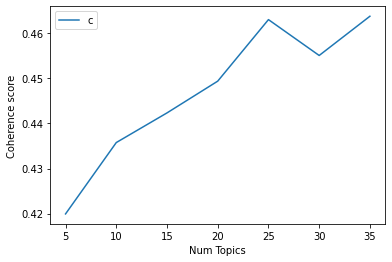

In [ ]:
limit=40; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.4199
Num Topics = 10  has Coherence Value of 0.4358
Num Topics = 15  has Coherence Value of 0.4423
Num Topics = 20  has Coherence Value of 0.4494
Num Topics = 25  has Coherence Value of 0.463
Num Topics = 30  has Coherence Value of 0.4551
Num Topics = 35  has Coherence Value of 0.4638


In [ ]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(14,
  '0.054*"hike" + 0.053*"enjoy" + 0.043*"run" + 0.036*"bike" + '
  '0.032*"outdoors" + 0.029*"active" + 0.025*"ride" + 0.023*"camping" + '
  '0.022*"travel" + 0.018*"hiking"'),
 (15,
  '0.280*"people" + 0.131*"meet" + 0.050*"friend" + 0.048*"person" + '
  '0.039*"thing" + 0.032*"interesting" + 0.031*"talk" + 0.024*"make" + '
  '0.022*"open" + 0.021*"find"'),
 (10,
  '0.085*"work" + 0.050*"school" + 0.026*"year" + 0.023*"college" + '
  '0.023*"start" + 0.021*"study" + 0.020*"high" + 0.020*"job" + '
  '0.017*"graduate" + 0.015*"business"'),
 (1,
  '0.079*"play" + 0.076*"watch" + 0.070*"movie" + 0.067*"enjoy" + '
  '0.050*"sport" + 0.044*"game" + 0.031*"love" + 0.026*"fan" + 0.019*"friend" '
  '+ 0.018*"tv"'),
 (12,
  '0.070*"friend" + 0.051*"family" + 0.050*"live" + 0.035*"year" + 0.033*"kid" '
  '+ 0.031*"time" + 0.031*"part" + 0.029*"life" + 0.028*"grow" + '
  '0.026*"close"'),
 (9,
  '0.015*"dog" + 0.015*"wear" + 0.014*"cat" + 0.011*"car" + 0.009*"walk" + '
  '0.008*"hand" + 0.0

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.1533,"dog, wear, cat, car, walk, hand, dress, hot, f...",about me: i would love to think that i was so...
1,1,16.0,0.0899,"food, good, eat, cook, drink, wine, day, walk,...",i am a chef: this is what that means. 1. i am ...
2,2,4.0,0.1432,"profile, write, read, message, word, question,...","i'm not ashamed of much, but writing public te..."
3,3,10.0,0.0713,"work, school, year, college, start, study, hig...",i work in a library and go to school. . .
4,4,4.0,0.0838,"profile, write, read, message, word, question,...",hey how's it going? currently vague on the pro...
5,5,11.0,0.0722,"good, sense, humor, laugh, make, conversation,...","i'm an australian living in san francisco, but..."
6,6,11.0,0.0735,"good, sense, humor, laugh, make, conversation,...",life is about the little things. i love to lau...
7,7,22.0,0.0759,"music, love, dance, play, listen, show, dancin...",my names jake. i'm a creative guy and i look f...
8,8,16.0,0.0852,"food, good, eat, cook, drink, wine, day, walk,...","update: i'm seeing someone, so off the market ..."
9,9,19.0,0.1088,"year, move, live, bear, back, bay_area, city, ...","i was born in wisconsin, grew up in iowa, and ..."


In [ ]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.3071,"people, good, friend, meet, time, person, guy,...","around new people i'm pretty shy and quiet, bu..."
1,1,6.0,0.1748,"relationship, woman, give, date, long, profile...",(movie preview voice) passion. desire. intrigu...
2,2,3.0,0.2105,"music, play, movie, watch, food, eat, hike, co...","21 year old student, born and raised in the ba..."
3,3,7.0,0.1378,"people, good, friend, meet, time, person, guy,...",i'm simple only that i can say
4,4,7.0,0.1830,"people, good, friend, meet, time, person, guy,...",down to earth. independent. friendly. dorky. f...
5,5,3.0,0.1729,"music, play, movie, watch, food, eat, hike, co...","fun, quirky, and armed with a nice repertoire ..."
6,6,0.0,0.1449,"life, world, share, feel, experience, importan...",-sf native -in advertising -dedicated -optimis...
7,7,3.0,0.2785,"music, play, movie, watch, food, eat, hike, co...","enjoying my new ""sf life""... i stay active and..."
8,8,6.0,0.2124,"relationship, woman, give, date, long, profile...","looking for ms. right -- ms. right now, that i..."
9,9,4.0,0.1851,"bit, make, stuff, girl, thing, read, bad, feel...",i'm an artist till the day i die. i live and b...


In [ ]:
df_dominant_topic.to_csv("okcupid60k_25topics2.csv")

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2009,"thing, make, lot, feel, people, bit, find, lea...",i am always changing. there are definitely id...
1,1.0,0.2553,"play, watch, movie, enjoy, sport, game, love, ...",i love sports! i play basketball every week an...
2,2.0,0.4267,"social, prefer, human, tend, involve, politic,...",occupy wall street. if my third-grade report ...
3,3.0,0.2396,"life, enjoy, share, find, live, experience, gr...",i am a socially aware geek who has an optimist...
4,4.0,0.6659,"profile, write, read, message, word, question,...",500 words 500 words 500 words 500 words 500 wo...


In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,9.0,"dog, wear, cat, car, walk, hand, dress, hot, f...",1649.0,0.0303
1.0,16.0,"food, good, eat, cook, drink, wine, day, walk,...",2537.0,0.0466
2.0,4.0,"profile, write, read, message, word, question,...",2009.0,0.0369
3.0,10.0,"work, school, year, college, start, study, hig...",1877.0,0.0345
4.0,4.0,"profile, write, read, message, word, question,...",2883.0,0.0529
...,...,...,...,...
54453.0,3.0,"life, enjoy, share, find, live, experience, gr...",NaN,NaN
54454.0,9.0,"dog, wear, cat, car, walk, hand, dress, hot, f...",NaN,NaN
54455.0,1.0,"play, watch, movie, enjoy, sport, game, love, ...",NaN,NaN
54456.0,8.0,"bad, hate, talk, make, awesome, stuff, call, w...",NaN,NaN


In [ ]:
%pip freeze >> requirements.txt

In [ ]:
optimal_model

In [ ]:
from gensim.test.utils import datapath

In [ ]:
temp_file = datapath("/content/drive/MyDrive/lda_model")

lda_model.save(temp_file)

In [37]:
from gensim import  models

lda = models.ldamodel.LdaModel.load(temp_file)